In [2]:
from pandas import read_csv
from datetime import datetime


In [3]:
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# drop the first 24 hours- it doesn't acctually delete it from csv, just load the dataset after 24th index i.e.,(0-23)
dataset = dataset[24:]

# summarize first 5 rows
print(dataset.head(5))

# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


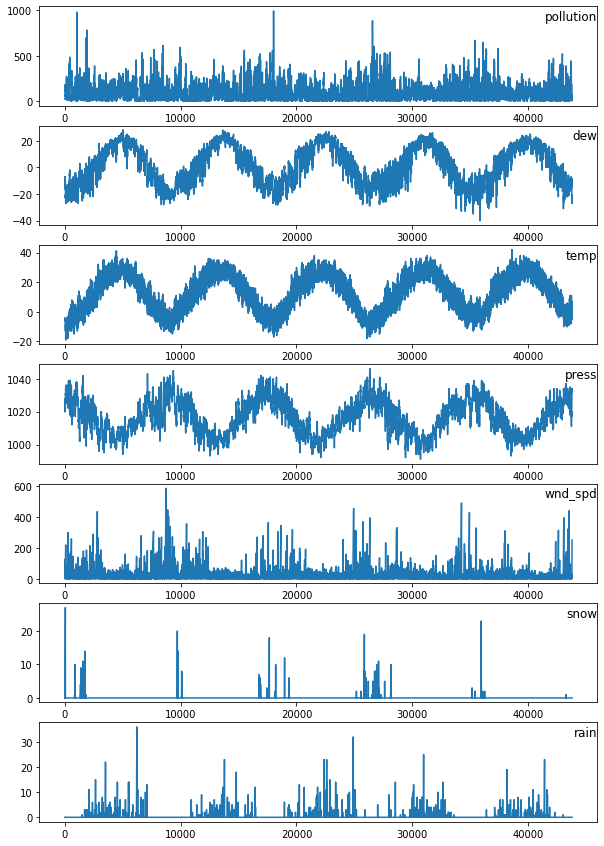

In [6]:
from pandas import read_csv
from matplotlib import pyplot
#loading newly written csv


# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot except wind direction [4] as it is categorical
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(10,15))
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group]) # values[r,c]
	pyplot.title(dataset.columns[group], y=0.8, loc='right')
	i += 1
pyplot.show()



In [7]:
#prepare data for LSTM 

from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [8]:
# integer encode direction (encoding categorical variable)
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [9]:
print(scaled.shape)
print(scaled)

(43800, 8)
[[0.12977867 0.35294122 0.24590163 ... 0.00229001 0.         0.        ]
 [0.14889336 0.36764708 0.24590163 ... 0.00381099 0.         0.        ]
 [0.15995975 0.4264706  0.22950819 ... 0.00533197 0.         0.        ]
 ...
 [0.01006036 0.2647059  0.26229507 ... 0.41399646 0.         0.        ]
 [0.00804829 0.2647059  0.24590163 ... 0.4208665  0.         0.        ]
 [0.01207243 0.2794118  0.26229507 ... 0.42621556 0.         0.        ]]


In [10]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [11]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [12]:
print(reframed)

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2       0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3       0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4       0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5       0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   
...          ...        ...        ...        ...        ...        ...   
43795   0.010060   0.264706   0.278689   0.763638   0.333333   0.385730   
43796   0.008048   0.250000   0.278689   0.781818   0.333333   0.395659   
43797   0.010060   0.264706   0.262295   0.781818   0.333333   0.405588   
43798   0.010060   0.264706   0.262295   0.781818   0.333333   0.413996   
43799   0.008048   0.264706   0.245902   0.781818   0.333333   0.420866   

       var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1       0.000000  

In [13]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


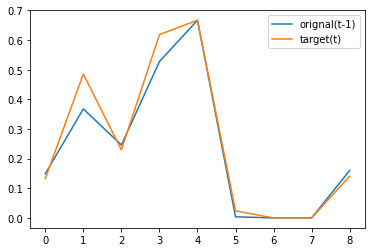

In [20]:
values = reframed.values

pyplot.plot(values[1],label='orignal(t-1)')
pyplot.plot(values[9], label='target(t)')
pyplot.legend()
pyplot.show()

In [11]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[n_train_hours:, :]
test = values[:n_train_hours, :]
print(train)
print("\n")
print(test)


[[0.0362173  0.33823532 0.1967213  ... 0.         0.         0.03118712]
 [0.03118712 0.33823532 0.1967213  ... 0.         0.         0.02012072]
 [0.02012072 0.33823532 0.1967213  ... 0.         0.         0.01911469]
 ...
 [0.01006036 0.2647059  0.26229507 ... 0.         0.         0.01006036]
 [0.01006036 0.2647059  0.26229507 ... 0.         0.         0.00804829]
 [0.00804829 0.2647059  0.24590163 ... 0.         0.         0.01207243]]


[[0.12977867 0.35294122 0.24590163 ... 0.         0.         0.14889336]
 [0.14889336 0.36764708 0.24590163 ... 0.         0.         0.15995975]
 [0.15995975 0.4264706  0.22950819 ... 0.         0.         0.18209255]
 ...
 [0.         0.32352942 0.22950819 ... 0.         0.         0.        ]
 [0.         0.32352942 0.16393442 ... 0.         0.         0.        ]
 [0.         0.33823532 0.1967213  ... 0.         0.         0.0362173 ]]


In [12]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X)
print("\n")
print(train_y)

[[0.0362173  0.33823532 0.1967213  ... 0.12757413 0.         0.        ]
 [0.03118712 0.33823532 0.1967213  ... 0.006101   0.         0.        ]
 [0.02012072 0.33823532 0.1967213  ... 0.0145091  0.         0.        ]
 ...
 [0.01006036 0.2647059  0.26229507 ... 0.40558836 0.         0.        ]
 [0.01006036 0.2647059  0.26229507 ... 0.41399646 0.         0.        ]
 [0.00804829 0.2647059  0.24590163 ... 0.4208665  0.         0.        ]]


[0.03118712 0.02012072 0.01911469 ... 0.01006036 0.00804829 0.01207243]


In [13]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35039, 1, 8) (35039,) (8760, 1, 8) (8760,)


Epoch 1/50
548/548 - 2s - loss: 0.0332 - val_loss: 0.0306
Epoch 2/50
548/548 - 1s - loss: 0.0141 - val_loss: 0.0199
Epoch 3/50
548/548 - 1s - loss: 0.0137 - val_loss: 0.0198
Epoch 4/50
548/548 - 1s - loss: 0.0137 - val_loss: 0.0191
Epoch 5/50
548/548 - 1s - loss: 0.0137 - val_loss: 0.0188
Epoch 6/50
548/548 - 0s - loss: 0.0137 - val_loss: 0.0192
Epoch 7/50
548/548 - 1s - loss: 0.0136 - val_loss: 0.0186
Epoch 8/50
548/548 - 1s - loss: 0.0135 - val_loss: 0.0168
Epoch 9/50
548/548 - 1s - loss: 0.0135 - val_loss: 0.0182
Epoch 10/50
548/548 - 1s - loss: 0.0135 - val_loss: 0.0165
Epoch 11/50
548/548 - 1s - loss: 0.0134 - val_loss: 0.0177
Epoch 12/50
548/548 - 1s - loss: 0.0135 - val_loss: 0.0161
Epoch 13/50
548/548 - 1s - loss: 0.0133 - val_loss: 0.0160
Epoch 14/50
548/548 - 0s - loss: 0.0133 - val_loss: 0.0162
Epoch 15/50
548/548 - 1s - loss: 0.0133 - val_loss: 0.0158
Epoch 16/50
548/548 - 1s - loss: 0.0134 - val_loss: 0.0159
Epoch 17/50
548/548 - 1s - loss: 0.0134 - val_loss: 0.0159
Epoch 

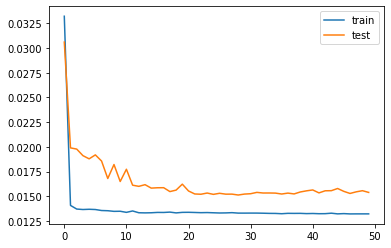

In [66]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [61]:
pred_y=model.predict(test_X)


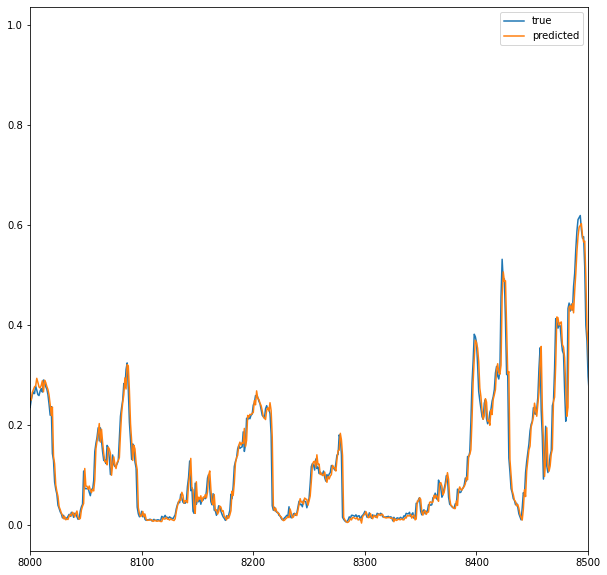

In [62]:
# plot true vs predicted
pyplot.figure(figsize=(10,10))
pyplot.plot(test_y, label='true')
pyplot.plot(pred_y, label='predicted')
pyplot.legend()
pyplot.xlim(8000, 8500)
pyplot.show()

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print("Mean Squared Error= ",mean_squared_error(test_y, pred_y))
print("Mean Absolute Error= ",mean_absolute_error(test_y, pred_y))


Mean Squared Error=  0.00097295304
Mean Absolute Error=  0.015191219


In [58]:
print(test_y)

[0.14889336 0.15995975 0.18209255 ... 0.         0.         0.0362173 ]


In [59]:
print(pred_y)

[[0.13503546]
 [0.1542339 ]
 [0.16753888]
 ...
 [0.00154684]
 [0.00090795]
 [0.00111889]]
